Failed to load image: tanda_tangan/TANDA TANGAN KELAS A/TTD MARSYA CIKITA/IMG_4032(1).HEIC
Failed to load image: tanda_tangan/TANDA TANGAN KELAS A/TTD MARSYA CIKITA/IMG_4031(3).HEIC
Failed to load image: tanda_tangan/TANDA TANGAN KELAS A/TTD MARSYA CIKITA/IMG_4031(4).HEIC
Failed to load image: tanda_tangan/TANDA TANGAN KELAS A/TTD MARSYA CIKITA/IMG_4031(9).HEIC
Failed to load image: tanda_tangan/TANDA TANGAN KELAS A/TTD MARSYA CIKITA/IMG_4031(2).HEIC
Failed to load image: tanda_tangan/TANDA TANGAN KELAS A/TTD MARSYA CIKITA/IMG_4031(6).HEIC
Failed to load image: tanda_tangan/TANDA TANGAN KELAS A/TTD MARSYA CIKITA/IMG_4031(10).HEIC
Failed to load image: tanda_tangan/TANDA TANGAN KELAS A/TTD MARSYA CIKITA/IMG_4031(1).HEIC
Failed to load image: tanda_tangan/TANDA TANGAN KELAS A/TTD MARSYA CIKITA/IMG_4031(8).HEIC
Failed to load image: tanda_tangan/TANDA TANGAN KELAS A/TTD MARSYA CIKITA/IMG_4031(5).HEIC
Failed to load image: tanda_tangan/TANDA TANGAN KELAS A/TTD MARSYA CIKITA/IMG_4032(2).HEI

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


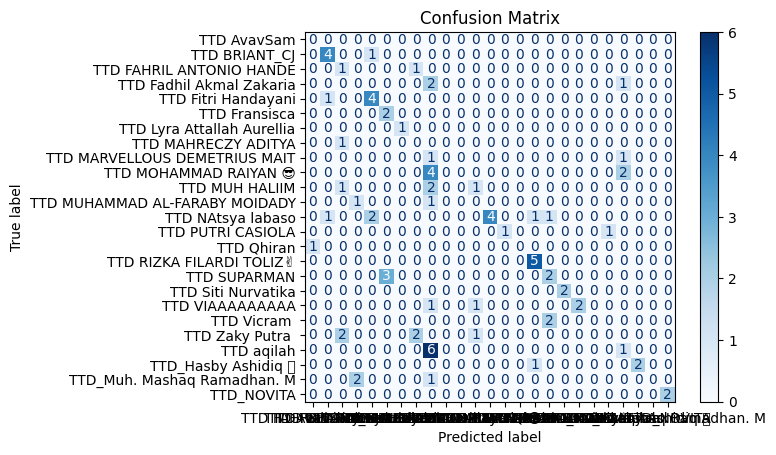


Akurasi Validasi: 40.96%


In [ ]:
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

# Lokasi file ZIP
zip_path = '/content/TANDA TANGAN KELAS A 😎-20241219T133546Z-001.zip'
extract_to = 'tanda_tangan'

# Ekstraksi
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Direktori utama
folder_path = os.path.join(extract_to, 'TANDA TANGAN KELAS A')

img_name = []
lbl_name = []

# Membaca gambar dan label dari tiap file
def baca_gambar_label(folder_path):
    for folder_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, folder_name)
        if os.path.isdir(file_path):  # Pastikan hanya folder yang dibaca
            for file_name in os.listdir(file_path):
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg', 'heic', 'webp')):
                    gambar = cv2.imread(os.path.join(file_path, file_name))
                    if gambar is not None:
                        gambar = cv2.resize(gambar, (150, 150))  # Resize ke 150x150 piksel
                        img_name.append(gambar)
                        lbl_name.append(folder_name)
                    else:
                        print(f"Failed to load image: {os.path.join(file_path, file_name)}")
                else:
                    print(f"Skipping non-image file: {os.path.join(file_path, file_name)}")

baca_gambar_label(folder_path)
img_name = np.array(img_name) / 255.0  # Normalisasi piksel gambar
lbl_name = np.array(lbl_name)

# Membagi dataset menjadi train dan validation
def split_data(img_name, lbl_name, validation_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(img_name, lbl_name, test_size=validation_size, random_state=42)
    return X_train, X_val, y_train, y_val

X_train, X_val, y_train, y_val = split_data(img_name, lbl_name)

def augment_data_per_class(X_train, y_train):
    unique_labels = np.unique(y_train)
    augmented_images = []
    augmented_labels = []

    for label in unique_labels:
        class_images = X_train[y_train == label]

        datagen = ImageDataGenerator(
            rotation_range=45,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='reflect'
        )

        datagen.fit(class_images)

        for i in range(len(class_images)):
            augmented_image = next(datagen.flow(class_images[i:i+1], batch_size=1))
            augmented_images.append(augmented_image[0])
            augmented_labels.append(label)

    return np.array(augmented_images), np.array(augmented_labels)

# Augmentasi data latih berdasarkan kelas
X_train_augmented, y_train_augmented = augment_data_per_class(X_train, y_train)

# Fungsi untuk meratakan gambar menjadi vektor 1D
def flatten_images(images):
    return images.reshape(images.shape[0], -1)

# Fungsi untuk melakukan Label Encoding
def encode_labels(labels):
    label_encoder = LabelEncoder()
    return label_encoder.fit_transform(labels), label_encoder

# Fungsi untuk melatih model SVM
def train_svm(X_train, y_train):
    model = SVC(kernel='linear')
    model.fit(X_train, y_train)
    return model

# Fungsi untuk mengevaluasi model
def evaluate_model(model, X_val, y_val):
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    return val_accuracy

# Fungsi untuk melatih dan mengevaluasi model SVM
def svm_image_classification(X_train, y_train, X_val, y_val):
    X_train_flat = flatten_images(X_train)
    X_val_flat = flatten_images(X_val)

    y_train_encoded, label_encoder = encode_labels(y_train)
    y_val_encoded = label_encoder.transform(y_val)

    model = train_svm(X_train_flat, y_train_encoded)

    val_accuracy = evaluate_model(model, X_val_flat, y_val_encoded)

    return val_accuracy, model, y_val_encoded, label_encoder

# Fungsi untuk menampilkan confusion matrix
def plot_confusion_matrix(y_true, y_pred, label_encoder):
    cm = confusion_matrix(y_true, y_pred)

    # Get all unique labels from both y_true and y_pred
    unique_labels = np.union1d(np.unique(y_true), np.unique(y_pred))

    labels = label_encoder.inverse_transform(unique_labels)  # Konversi ke nama kelas
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d')  # Menampilkan nilai dalam format integer
    plt.title('Confusion Matrix')
    plt.show()


# Menjalankan klasifikasi dan mendapatkan prediksi
val_accuracy, model, y_val_encoded, label_encoder = svm_image_classification(X_train_augmented, y_train_augmented, X_val, y_val)

# Memprediksi pada data validasi
y_val_pred = model.predict(flatten_images(X_val))

# Menampilkan confusion matrix dengan label yang sesuai
plot_confusion_matrix(y_val_encoded, y_val_pred, label_encoder)

print(f"\nAkurasi Validasi: {val_accuracy * 100:.2f}%")

